<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab12_nlp-introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12 - Natural Language Processing - Introduction

### Author: Szymon Nowakowski


# Introduction
---------------
In this class, we take our first steps into Natural Language Processing (NLP). We'll begin by averaging word embeddings to form sentence-level representations—a simple but effective baseline. **Attention** generalizes this idea by learning which words matter more in context, assigning dynamic weights instead of treating each word equally. In this sense, **attention can be thought of as a learned, weighted average**.

This is our gateway into more advanced techniques. In the next class, we’ll study **self-attention**, the backbone of modern architectures like the Transformer. And if time permits, we may even explore the **full Transformer** model in our final class.

I would like to express my gratitude to my colleague Przemysław Olbratowski for this elegant way of introducing attention, which I find both intuitive and pedagogically effective.


### Yelp Reviews Polarity Dataset  
--------------

This dataset contains **over 560k full-text reviews** from Yelp, labeled for **binary sentiment**:  
- **positive** (5-star reviews)  
- **negative** (1-star reviews)  

We will not use the full dataset, because it cannot be handled by Colab RAM. We will use short sequences with the word `but`.

Each example is a **real user-generated review**, typically 2–5 sentences long, capturing clear and direct sentiment in natural language.  
There are no ambiguous or neutral labels, making this dataset ideal for training and evaluating **binary sentiment classifiers**.

The dataset was curated and released as part of the **FastText** and **Text Classification Benchmarks** by researchers at Facebook AI. It is widely used for benchmarking sentiment models in both academia and industry.


In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
import collections
import re                             # Regular Expressions: for text searching and cleaning

MAX_LEN = 64
pattern = re.compile(r"\bbut\b", flags=re.IGNORECASE)

# Load dataset
raw = load_dataset("yelp_polarity")

# Define fast batch filter function
def batch_filter(batch):
    return [
        bool(pattern.search(text)) and len(text.split()) <= MAX_LEN
        for text in batch["text"]
    ]

# Filter with batching
train_raw = raw["train"].filter(batch_filter, batched=True, batch_size=1000)
test_raw  = raw["test"].filter(batch_filter, batched=True, batch_size=1000)

# Extract plain Python lists for text and labels
def to_lists(dataset):
    texts = []
    labels = []
    for example in dataset:
        texts.append(example["text"])
        labels.append(example["label"])
    return texts, labels

train_texts, train_labels = to_lists(train_raw)
test_texts, test_labels   = to_lists(test_raw)

# Split test set into val/test
from sklearn.model_selection import train_test_split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

# Show class counts
def print_distribution(name, labels):
    c = collections.Counter(labels)
    total = sum(c.values())
    print(f"\n{name} distribution:")
    for label in sorted(c.keys()):
        print(f"  {label}: {c[label]} ({c[label]/total:.2%})")

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Train distribution:
  0: 22172 (48.48%)
  1: 23560 (51.52%)

Validation distribution:
  0: 756 (48.00%)
  1: 819 (52.00%)

Test distribution:
  0: 755 (47.94%)
  1: 820 (52.06%)


## Some examples

In [3]:
label_map = {0: "negative", 1: "positive"}

for i in range(10):
    print(f"[{label_map[train_labels[i]]}] {train_texts[i]}\n")

[negative] Wing sauce is like water. Pretty much a lot of butter and some hot sauce (franks red hot maybe).  The whole wings are good size and crispy, but for $1 a wing the sauce could be better. The hot and extra hot are about the same flavor/heat.  The fish sandwich is good and is a large portion, sides are decent.

[positive] Italian dinners, American, endless soup and salad bar is great. Most food for your dollar. I highly recommend. Great bar. Good place to watch a game. The bar can get quite noisy in the evenings, but it adds to the great atmosphere at Rocky's

[positive] Definitely a greasy spoon! Always packed here and always a wait but worth it. The omelets are really tastey especially with their homemade sausage. I also like the mixed grill.  My parents love their burgers. Took off a star for lumpy booths and really tight tables (your arm gets hit when someone walks past) oh and waitresses aren't very attentive.

[positive] Went for breakfast on 6/16/14. We received very good

# Tokenizer
-------------------

To feed text into a neural network, we need to represent words in a "neural-network-ish" way — that is, as numbers. The standard approach is to use a tokenizer, often from a pretrained model. However, since we plan to experiment with our own attention modules later on, **we’ll avoid using any pretrained tokenizer**.

Instead, we’ll go with a simple, word-based tokenization. As part of this, we’ll clean the text by removing any non-standard HTML tags, digits, extra whitespace, and punctuation. We’ll also convert all words to lowercase to ensure consistency.

## Special Tokens: `<PAD>` and `<UNK>`

In our text preprocessing pipeline, we convert each word to a number using a vocabulary. Two special tokens help us handle padding and unknown words.




### `<PAD>` — Padding Token

- Represents empty slots when we need all input sequences to be the same length.
- Assigned index `0`.
- Used so that batches of sentences can be processed together by the model.

*For example:*

Original: `[17, 5, 23]`  
Padded:   `[17, 5, 23, 0, 0]` (for a fixed length of 5)




### `<UNK>` — Unknown Token

- Represents any word that is **not in the vocabulary**.
- Assigned index `1`.
- Occurs when:
  1. A word was **too rare in the training data** (appeared only once and was excluded from the vocabulary).
  2. A word appears **only in validation or test data**.

> In our setup, we **excluded all words that appear only once** in the training set.  
> So even in the training data, some tokens are replaced with `<UNK>`.  
> These are called **rare unknowns** — they help the model learn how to handle unusual or unfamiliar words.


By including `<UNK>` during training, we teach the model how to deal with unseen or rare words at test time — which is **crucial for generalization**.


In [4]:


def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def build_vocab(token_lists, min_freq=2):
    counter = collections.Counter(token for tokens in token_lists for token in tokens)
    vocab = {
        token: idx + 2  # reserve 0: <PAD>, 1: <UNK>
        for idx, (token, count) in enumerate(counter.items())
        if count >= min_freq
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(tok, vocab['<UNK>']) for tok in tokens]   #for unknown tokens return vocab['<UNK>'] (which is == 1)

def pad(seq, max_len=128, pad_value=0):
    return seq + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def process_texts(texts, vocab, max_len=128):
    return [pad(tokens_to_ids(tokenize(text), vocab), max_len) for text in texts]


# Tokenize training set and build vocab
train_tokens = [tokenize(t) for t in train_texts]
vocab = build_vocab(train_tokens)

# Process splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Print 5 real examples: raw text, tokenized, and input IDs
shown = 0
for i in range(len(train_texts)):
    if 1 in train_ids[i][:5]:  # 1 is <UNK>
        print(f"Original:   {train_texts[i]}")
        print(f"Tokenized:  {train_tokens[i]}")
        print(f"Input IDs:  {train_ids[i]}\n")
        shown += 1
        if shown >= 5:
            break





Original:   Wham! 4 stars outta the park! The deep-dish pizza we had was amazing. I wasn't crazy about the avocado egg rolls, but the chocolate chip sundae was superb. Great service too from Maranda, a doll. Decor is cute. Ambience is lively. Recommended.
Tokenized:  ['wham', 'stars', 'outta', 'the', 'park', 'the', 'deep', 'dish', 'pizza', 'we', 'had', 'was', 'amazing', 'i', 'wasn', 't', 'crazy', 'about', 'the', 'avocado', 'egg', 'rolls', 'but', 'the', 'chocolate', 'chip', 'sundae', 'was', 'superb', 'great', 'service', 'too', 'from', 'maranda', 'a', 'doll', 'decor', 'is', 'cute', 'ambience', 'is', 'lively', 'recommended']
Input IDs:  [1, 478, 479, 19, 223, 19, 480, 481, 417, 119, 134, 131, 153, 54, 482, 113, 483, 32, 19, 484, 485, 486, 26, 19, 394, 487, 488, 131, 489, 49, 121, 441, 260, 1, 9, 491, 492, 4, 493, 494, 4, 495, 496, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Original:   Enjoyed the winter solstice concert Saturday night. Fun scene, cover benefited chari

## Notice!

Notice that the `<UNK>` token (coded as 1) is visible in the rows above. Also, there is an abundance of `<PAD>` tokens (coded as 0).

# Prepare Data Loaders
--------------------

We must transform the pandas dataframe to the dataset - it will, among other things, separate input data and labels and then wrap it in a dataloder.

In [5]:
import torch

BATCH_SIZE = 1024

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Convert all to tensors
def to_loader(input_ids, labels, batch_size=1024, shuffle=False):
    x_tensor = torch.tensor(input_ids, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# Training Loop as We Already Got to Know It Well
----------------

## Train Loop Function

In [6]:
import time
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, log_every=10):
    print(f"Working on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()  # shape: (batch_size)

            optimizer.zero_grad()
            logits = net(batch_inputs)  # logits shape: (batch_size, 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                logits = net(batch_inputs)
                loss = criterion(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Working on cpu


## Plot Function

In [7]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Simple 1 Feature Aproach

Before we proceed with 16-feature network, let's try to go simpler, for a moment. Let's consider a single feature.

Working on cpu
Epoch 000 | Train Loss: 0.8398, Acc: 0.5152 | Val Loss: 0.8245, Acc: 0.5200
Epoch 010 | Train Loss: 0.7090, Acc: 0.5244 | Val Loss: 0.7061, Acc: 0.5308
Epoch 020 | Train Loss: 0.6850, Acc: 0.5684 | Val Loss: 0.6846, Acc: 0.5663
Epoch 030 | Train Loss: 0.6730, Acc: 0.6002 | Val Loss: 0.6728, Acc: 0.6006
Epoch 040 | Train Loss: 0.6492, Acc: 0.6554 | Val Loss: 0.6482, Acc: 0.6489
Epoch 050 | Train Loss: 0.5996, Acc: 0.7346 | Val Loss: 0.5978, Acc: 0.7365
Epoch 060 | Train Loss: 0.5334, Acc: 0.8093 | Val Loss: 0.5326, Acc: 0.7981
Epoch 070 | Train Loss: 0.4765, Acc: 0.8377 | Val Loss: 0.4778, Acc: 0.8203
Epoch 080 | Train Loss: 0.4317, Acc: 0.8508 | Val Loss: 0.4351, Acc: 0.8381
Epoch 090 | Train Loss: 0.3956, Acc: 0.8623 | Val Loss: 0.4012, Acc: 0.8476
Epoch 100 | Train Loss: 0.3659, Acc: 0.8709 | Val Loss: 0.3738, Acc: 0.8616
Epoch 110 | Train Loss: 0.3409, Acc: 0.8788 | Val Loss: 0.3511, Acc: 0.8737
Epoch 120 | Train Loss: 0.3195, Acc: 0.8869 | Val Loss: 0.3323, Acc: 0.87

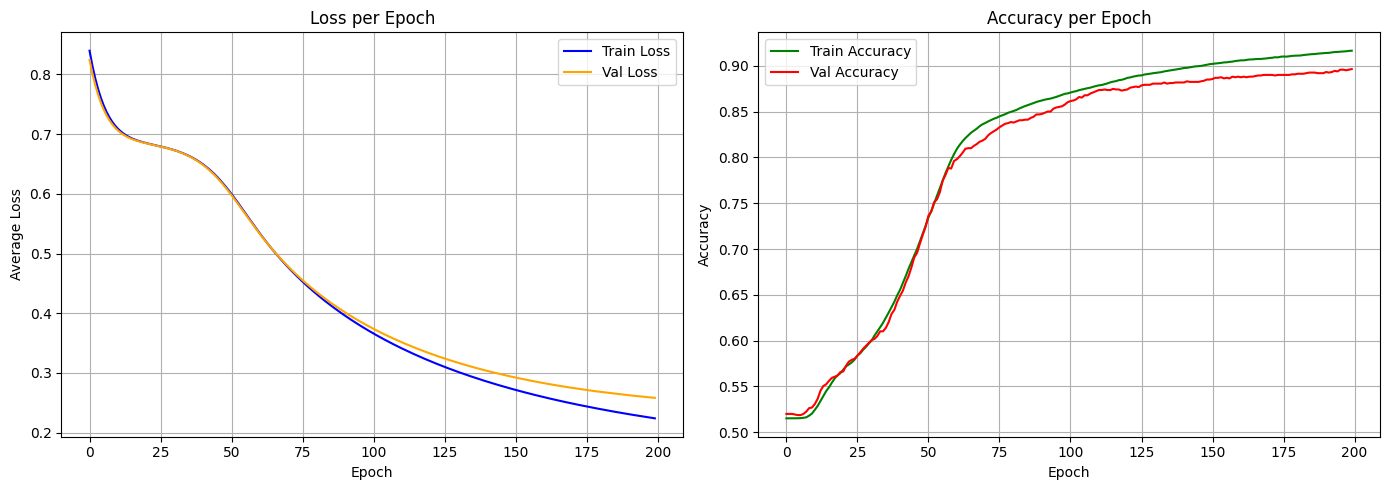

In [8]:
feature_cnt = 1
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_1 = Net_1()

# Execute training
train_loss, val_loss, train_acc, val_acc = train_model(net_1, train_loader, val_loader, epochs = 240)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

## Sentiment Polarity

Since our embeddings have only 1 feature (`feature_cnt = 1`), each word is embedded to a scalar. We can interpret this scalar as a kind of sentiment polarity, especially since our model is trained for sentiment classification.

In [9]:
import numpy as np

# Get the embedding weights as a NumPy array
embedding_weights = net_1.embedding.weight.detach().cpu().numpy().squeeze()  # shape: (vocab_len,)

# Reverse vocab dictionary to map indices back to words
id2token = {idx: token for token, idx in vocab.items()}

# Skip <PAD> and <UNK> tokens (indices 0 and 1)
valid_indices = np.array([idx for idx in range(2, len(embedding_weights)) if idx in id2token])
valid_embeddings = embedding_weights[valid_indices]

# Sort and select indices
sorted_pos = np.argsort(-valid_embeddings)
sorted_neg = np.argsort(valid_embeddings)
sorted_neutral = np.argsort(np.abs(valid_embeddings))

top_pos_indices = valid_indices[sorted_pos[:20]]
top_neg_indices = valid_indices[sorted_neg[:20]]
top_neutral_indices = valid_indices[sorted_neutral[:20]]

# Print words and corresponding embedding values
def print_words_with_embeddings(indices, title):
    print(f"\n{title}")
    for idx in indices:
        word = id2token[int(idx)]
        value = embedding_weights[int(idx)]
        print(f"{word:15} -> {value:.4f}")

print_words_with_embeddings(top_pos_indices, "Top 20 most positive words:")
print_words_with_embeddings(top_neg_indices, "Top 20 most negative words:")
print_words_with_embeddings(top_neutral_indices, "Top 20 most neutral words:")



Top 20 most positive words:
amazing         -> 9.6901
delish          -> 9.0397
fantastic       -> 8.5435
love            -> 8.4768
excellent       -> 8.4276
delicious       -> 8.2470
die             -> 8.1793
awesome         -> 8.1681
ngreat          -> 8.1658
affordable      -> 8.1517
yummy           -> 8.1298
perfectly       -> 8.0362
yum             -> 8.0105
perfection      -> 7.9605
great           -> 7.9422
perfect         -> 7.8530
juicy           -> 7.8061
solid           -> 7.7145
loved           -> 7.6532
wonderful       -> 7.6242

Top 20 most negative words:
bland           -> -9.5411
poor            -> -9.4103
meh             -> -8.8929
horrible        -> -8.8287
blah            -> -8.7701
sucks           -> -8.7545
dry             -> -8.5873
pinch           -> -8.5013
mediocre        -> -8.4750
worst           -> -8.3179
downhill        -> -8.2987
flavorless      -> -8.2071
garbage         -> -8.0472
rude            -> -7.9831
below           -> -7.9652
tasteless       -

## Classificator

It is interesting to see how the polar sentiment gets translated into the two  class values. Let's see:

In [10]:
# Extract weights and bias from the classifier layer
classifier_weight = net_1.classifier.weight.detach().cpu().numpy()
classifier_bias = net_1.classifier.bias.detach().cpu().numpy()

print("Classifier weights (shape: {}):".format(classifier_weight.shape))
print(classifier_weight)

print("\nClassifier bias (shape: {}):".format(classifier_bias.shape))
print(classifier_bias)

print("Recall our coding: ")
print(label_map)


Classifier weights (shape: (1, 1)):
[[6.8998113]]

Classifier bias (shape: (1,)):
[-0.21405357]
Recall our coding: 
{0: 'negative', 1: 'positive'}


In [11]:
# Hand-picked test sentences
texts = [
    "I love this!",
    "This is terrible",
    "Thank you so much!",
    "I hate this",
    "Wow, awesome!",
    "This sucks"
]

# Convert texts to input_ids using your tokenizer
input_ids = process_texts(texts, vocab)
input_tensor = torch.tensor(input_ids).to(next(net_1.parameters()).device)

# Predict with trained model
net_1.eval()
with torch.no_grad():
    logits = net_1(input_tensor).squeeze()
    probs = torch.sigmoid(logits)

# Print results
for text, prob in zip(texts, probs):
    print(f"{text:30} -> predicted probability of POSITIVE: {prob.item():.4f}")


I love this!                   -> predicted probability of POSITIVE: 0.6337
This is terrible               -> predicted probability of POSITIVE: 0.4203
Thank you so much!             -> predicted probability of POSITIVE: 0.5746
I hate this                    -> predicted probability of POSITIVE: 0.4541
Wow, awesome!                  -> predicted probability of POSITIVE: 0.6699
This sucks                     -> predicted probability of POSITIVE: 0.3926


# 16 Feature Network, Now

Working on cpu
Epoch 000 | Train Loss: 0.6902, Acc: 0.5322 | Val Loss: 0.6860, Acc: 0.5467
Epoch 010 | Train Loss: 0.5277, Acc: 0.8041 | Val Loss: 0.5151, Acc: 0.8102
Epoch 020 | Train Loss: 0.3689, Acc: 0.8660 | Val Loss: 0.3686, Acc: 0.8629
Epoch 030 | Train Loss: 0.2897, Acc: 0.8961 | Val Loss: 0.3024, Acc: 0.8832
Epoch 040 | Train Loss: 0.2460, Acc: 0.9107 | Val Loss: 0.2707, Acc: 0.8927
Epoch 050 | Train Loss: 0.2187, Acc: 0.9200 | Val Loss: 0.2542, Acc: 0.8971
Epoch 060 | Train Loss: 0.1996, Acc: 0.9260 | Val Loss: 0.2451, Acc: 0.9003
Epoch 070 | Train Loss: 0.1851, Acc: 0.9312 | Val Loss: 0.2409, Acc: 0.9022
Epoch 080 | Train Loss: 0.1735, Acc: 0.9359 | Val Loss: 0.2392, Acc: 0.9035
Epoch 090 | Train Loss: 0.1639, Acc: 0.9400 | Val Loss: 0.2397, Acc: 0.9060
Elapsed time: 135.25 seconds


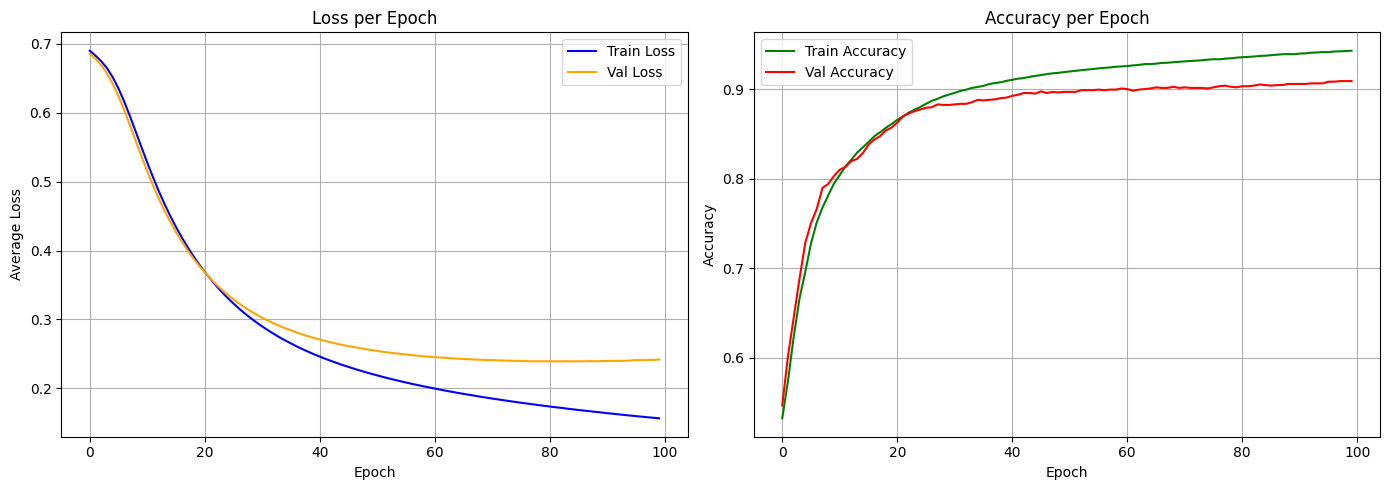

In [12]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_16(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_16=Net_16()
train_loss, val_loss, train_acc, val_acc = train_model(net_16, train_loader, val_loader, epochs=120)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# Towards Attention!



## The Entry Point

The entry point is our Net_16 model with averaged features:

In [13]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_16(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #SIZE: batch, words
        features = self.embedding(index)             #SIZE: batch, words, features

        ### This is where AVERAGING takes place
        features = features.mean(-2)                 #SIZE: batch, features


        classifications = self.classifier(features)  #SIZE: batch, 1
        logits = classifications.squeeze(-1)         #SIZE: batch
        return logits

## Less Explicit Averaging

The code below is equivalent to taking the `mean()` over words:

In [14]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_16_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        weights = torch.ones((batch, 1, words)) / words   # create EQUAL WEIGHT tensor summing to 1.0 ( words x (1/words) )
                                                         #SIZE: batch, 1, words
        features = weights @ features                    #SIZE: batch, 1, features


        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

And now let us refactor this, taking the weighted average part into a separate `Attention` module:

In [15]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features):                         #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        weights = torch.ones((batch, 1, words)) / words   # create EQUAL WEIGHT tensor summing to 1.0 ( words x (1/words) )
                                                         #SIZE: batch, 1, words
        features = weights @ features                    #SIZE: batch, 1, features
        return features

class Net_16_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

All that we did up until that point was to rewrite taking the `mean()` into a separate `Attention` which calculates the weighted averager with equal weights over weights.

## Introducing the Notion of Energy

Another useful concept is that of the energy. The energy equal to 0 uniformly for all words translates (with the use of `softmax`) into the equal weights, so the below version is still equivalent to what we already had (but, arguably, it looks much more complex):

In [16]:
import torch.nn.functional as F

feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = torch.zeros((batch, 1, words))       #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_16_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

## Something New - Learned Energies

In [ ]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.energy = torch.nn.Linear(feature_cnt, 1)
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = self.energy(features)                #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_16_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

net_att = Net_16_Towards_Attention()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_att, train_loader, val_loader, epochs = 80)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

Working on cpu
Epoch 000 | Train Loss: 0.6923, Acc: 0.5161 | Val Loss: 0.6888, Acc: 0.5371
Epoch 010 | Train Loss: 0.3886, Acc: 0.8342 | Val Loss: 0.3882, Acc: 0.8311
Epoch 020 | Train Loss: 0.2603, Acc: 0.8952 | Val Loss: 0.2886, Acc: 0.8844
Epoch 030 | Train Loss: 0.2183, Acc: 0.9134 | Val Loss: 0.2752, Acc: 0.8857
Epoch 040 | Train Loss: 0.1865, Acc: 0.9277 | Val Loss: 0.2768, Acc: 0.8876
